# Project - Data preprocessing

In [ ]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell

In [ ]:
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.precision', 3)

In [ ]:
# extra imports
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox

from distance_calculation import distance_to_paris

In [ ]:
data = 'dataset.csv'

## SECTION 1: READING THE FILE DATASET.CSV 

In [ ]:
dataRead = read_csv(data, header=0, delimiter=';')
dataRead.shape

 Question:

* Which is the target variable? where is it? how many different values? is it a classification problem or a regression problem?

* The target variable is located in column 3 and is called 'total_passengers_2022'; it has two possible values (therfore it is a classification problem)

In [ ]:
dataRead.columns

In [ ]:
dataRead[:4]

## SECTION 2: BASIC INSPECTION OF THE DATASET

In [ ]:
dataRead.describe()

Observations

Zero Values: Columns such as total_passengers_2022 and total_passengers_and_non_passengers_2022 have zero values. These may need special handling.

High Variability: Many columns, like total_passengers_2022, have high standard deviations, indicating significant variability in the data.

Missing Data: Columns like distr_histoires_courtes and total have significantly fewer entries, suggesting missing data that may need imputation or dropping.

Next Steps
Handle Missing Values: Impute or remove missing values appropriately.
Normalize Data: Normalize or standardize numerical columns to prepare for machine learning models.
Outlier Treatment: Identify and handle outliers in the data to ensure robust analysis

In [ ]:
#remove services except wifi, trigram, city code, uic, postal code, Total Voyageurs 2021, city_attraction_label, active_employers_2021, hotel_rooms_2024_sum, camping_sites_2024_sum.1
# split geographical_position
#Assign No for missing WIFI

columns_to_drop = [
    'trigram', 'city_code', 'uic', 'postal_code', 'Total Voyageurs 2021',
    'city_attraction_label', 'active_employers_2021', 'hotel_rooms_2024_sum',
    'camping_sites_2024_sum.1','power_station','baby_foot','piano', 'distr_histoires_courtes','total'
]
dataRead.drop(columns=columns_to_drop, axis=1, inplace=True)

# Splitting geographical_position into latitude and longitude
dataRead[['latitude', 'longitude']] = dataRead['geographical_position'].str.split(',', expand=True)
dataRead.drop(columns=['geographical_position'], axis=1, inplace=True)

dataRead.describe()
dataRead.columns

## SECTION 3: DEALING WITH MISSING VALUES

First we decide to remove the missing values for some of the numerical variables as there are few of them.

In [ ]:
(dataRead.total_passengers_2022	==0).value_counts()
(dataRead.total_passengers_and_non_passengers_2022	==0).value_counts()
(dataRead.total_passengers_2015	==0).value_counts()
(dataRead.total_passengers_and_non_passengers_2015	==0).value_counts()


In [ ]:
dataRead=  dataRead[(dataRead.total_passengers_2022!=0) & (dataRead.total_passengers_and_non_passengers_2022!=0) 
                    & (dataRead.total_passengers_2015!=0) & (dataRead.total_passengers_and_non_passengers_2015!=0)]
dataRead.shape

We identified that the `wifi_service` column contains the values 'Non' (No), 'Oui' (Yes), and some missing values (`NaN`). The distribution of these values was as follows:

- **Non**: 2106
- **Oui**: 120
- **NaN**: 8

### Strategy

To handle the missing values and convert the categorical values to binary, we:
1. Removed rows with `NaN` values in the `wifi_service` column.
2. Converted 'Oui' to 1 and 'Non' to 0.

In [ ]:
# Remove rows with NaN values in wifi_service
dataRead = dataRead.dropna(subset=['wifi_service'])

# Convert 'Oui' to 1 and 'Non' to 0 in wifi_service
dataRead['wifi_service'] = dataRead['wifi_service'].map({'Oui': 1, 'Non': 0})

# Display the updated frequency of each value in wifi_service column
wifi_service_value_counts = dataRead['wifi_service'].value_counts(dropna=False)
wifi_service_value_counts

## SECTION 4: FINDING OUTLIERS

In real data you are usually going to find outliers. It can be because the data is just like that or because there are wrong values stored.

It is important to identify them so you can remove them, impute them, or just acknowledge their existence and take into account in your analysis.

Some machine learning models are very sensitive to outliers.

There are a lot of ways to define an outlier. Here we are going to talk about a basic and a complex one.

In [ ]:
numerical_columns = [
    'total_passengers_2022',
    'total_passengers_and_non_passengers_2022',
    'total_passengers_2015',
    'total_passengers_and_non_passengers_2015',
    'sum_municipal_population_2021',
    'non_scholarized_15_years_old_or_more_2020',
    'main_residences_2020',
    'housing_2020',
    'jobs_at_workplace_2020',
    'hotels_2024_sum',
    'camping_sites_2024_sum',
    'other_tourist_accommodations_2024_sum'
]

# Box plots for numerical variables
for col in numerical_columns:
    plt.figure(figsize=(10, 5))
    dataRead.boxplot(column=[col])
    plt.title(f'Box plot for {col}')
    plt.show()

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
dataRead.boxplot(column='total_passengers_2022',ax=axes[0]);
dataRead.hist(column='total_passengers_2022', ax=axes[1]);

In [ ]:
Q1 = dataRead['total_passengers_2022'].quantile(0.25)
Q3 = dataRead['total_passengers_2022'].quantile(0.75)
IQR = Q3 - Q1

Q1, Q3, IQR

small_outliers = dataRead['total_passengers_2022'] < (Q1 - 1.5 * IQR)
big_outliers = dataRead['total_passengers_2022'] > (Q3 + 1.5 * IQR)

sum(small_outliers), sum(big_outliers)

dataRead['total_passengers_2022'][small_outliers | big_outliers].head()
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
dataRead[~(small_outliers | big_outliers)].boxplot(column='total_passengers_2022',ax=axes[0]);
dataRead[~(small_outliers | big_outliers)].hist(column='total_passengers_2022', ax=axes[1]);

***
## SECTION 5: TREATMENT OF MIXED DATA TYPES


 In this case we have decided to keep the original type and leave the decision for later, depending on the specific analysis

 we explicitly declare categorical variables as such

In [ ]:
dataRead.dtypes

## SECTION 6: DERIVATION OF NEW VARIABLES: FEATURE EXTRACTION

 We decide whether it can be sensible to derive new variables

In [ ]:
# 1. Passenger Growth Rate
dataRead['passenger_growth_rate'] = (dataRead['total_passengers_2022'] - dataRead['total_passengers_2015']) / dataRead['total_passengers_2015']
dataRead['passenger_growth_rate'].hist(figsize=(8, 8))

In [ ]:
# 2. Attraction Density
dataRead['attraction_density'] = (dataRead['hotels_2024_sum'] + dataRead['camping_sites_2024_sum'] + dataRead['other_tourist_accommodations_2024_sum']) / dataRead['sum_municipal_population_2021']
dataRead['attraction_density'].hist(bins=16, figsize=(8, 8))

In [ ]:
# 3. City Size Category
def categorize_city_size(population):
    if population < 50000:
        return 'Small'
    elif 50000 <= population < 200000:
        return 'Medium'
    else:
        return 'Large'

dataRead['city_size_category'] = dataRead['sum_municipal_population_2021'].apply(categorize_city_size)

# Mark dubious cities based on passenger growth rate and municipal population
dataRead['Dubious'] = ['No'] * dataRead.shape[0]
dataRead.loc[
    (dataRead['passenger_growth_rate'] > dataRead['passenger_growth_rate'].median(skipna=True)) &
    (dataRead['sum_municipal_population_2021'] < 1.25 * dataRead['sum_municipal_population_2021'].mean(skipna=True)), 
    'Dubious'
] = "Yes"

# Crosstab of Dubious and city_size_category
dubious_crosstab = pd.crosstab(dataRead['Dubious'], dataRead['city_size_category'])
dubious_crosstab
dataRead[['passenger_growth_rate', 'attraction_density', 'city_size_category', 'Dubious']].head()


In [ ]:
# 4. Non passengers only
dataRead['total_non_passengers_2022'] = dataRead['total_passengers_and_non_passengers_2022'] - dataRead['total_passengers_2022']
dataRead['total_non_passengers_2015'] = dataRead['total_passengers_and_non_passengers_2015'] - dataRead['total_passengers_2015']

# 5. Non passenger growth rate
dataRead['non_passenger_growth_rate'] = (dataRead['total_passengers_and_non_passengers_2022'] - dataRead['total_passengers_and_non_passengers_2015']) / dataRead['total_passengers_and_non_passengers_2015']


In [ ]:
# 6. Distance to Paris
# Convert latitude and longitude to float
dataRead['latitude'] = dataRead['latitude'].astype(float)
dataRead['longitude'] = dataRead['longitude'].astype(float)

dataRead['distance_to_paris'] = dataRead.apply(lambda row: distance_to_paris(row['latitude'], row['longitude']), axis=1)

***
## SECTION 7: WHAT WE HAVE DONE SO FAR


 Create a new dataframe that gathers everything and inspect it again

In [ ]:
dataRead_new =dataRead.copy()

dataRead_new.describe(include='all')
dataRead_new.shape

***
## SECTION 8: GAUSSIANITY AND TRANSFORMATIONS


Performing a graphical summary of some of the variables helps understand their distributions, identify outliers, and assess the need for transformations to approximate a Gaussian (normal) distribution. This section covers histograms and boxplots for continuous variables, as well as bar charts for categorical variables.

In [ ]:
# List of continuous numerical columns
continuous_columns = [
    'total_passengers_2022',
    'total_passengers_and_non_passengers_2022',
    'total_passengers_2015',
    'total_passengers_and_non_passengers_2015',
    'total_non_passengers_2022',
    'total_non_passengers_2015',
    'passenger_growth_rate',
    'non_passenger_growth_rate',
    'attraction_density'
]

# Plot histograms for continuous variables
for col in continuous_columns:
    plt.figure(figsize=(8, 8))
    plt.hist(dataRead_new[col].dropna(), bins=30, edgecolor='k', alpha=0.7, color='green')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
# Plot boxplots for continuous variables
for col in continuous_columns:
    plt.figure(figsize=(8, 8))
    dataRead_new.boxplot(column=[col])
    plt.title(f'Box plot of {col}')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

In [ ]:
pd.options.mode.use_inf_as_na = True

# Apply log transformation and plot histograms
log_transformed_columns = ['total_passengers_2022',
                           'total_passengers_and_non_passengers_2022',
                           'total_non_passengers_2022',
                           'total_passengers_2015',
                           'total_passengers_and_non_passengers_2015',
                           'total_non_passengers_2015']

for col in log_transformed_columns:
    plt.figure(figsize=(8, 8))
    dataRead_new[col].apply(np.log1p).hist(bins=30, edgecolor='k', alpha=0.7, color='red')
    plt.title(f'Log-Transformed Histogram of {col}')
    plt.xlabel(f'log1p({col})')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
# List of categorical columns
categorical_columns = [
    'drg_segment',
    'city_label',
    'city_attraction_area',
    'city_size_category',
    'Dubious'
]

# Plot bar charts for categorical variables
for col in categorical_columns:
    plt.figure(figsize=(8, 8))
    dataRead_new[col].value_counts().plot(kind='bar', edgecolor='k', alpha=0.7, color='blue')
    plt.title(f'Bar chart of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

<Axes: xlabel='population_category'>

Text(0.5, 1.0, 'Bar chart of population categories')

Text(0.5, 0, 'Population Category')

Text(0, 0.5, 'Frequency')

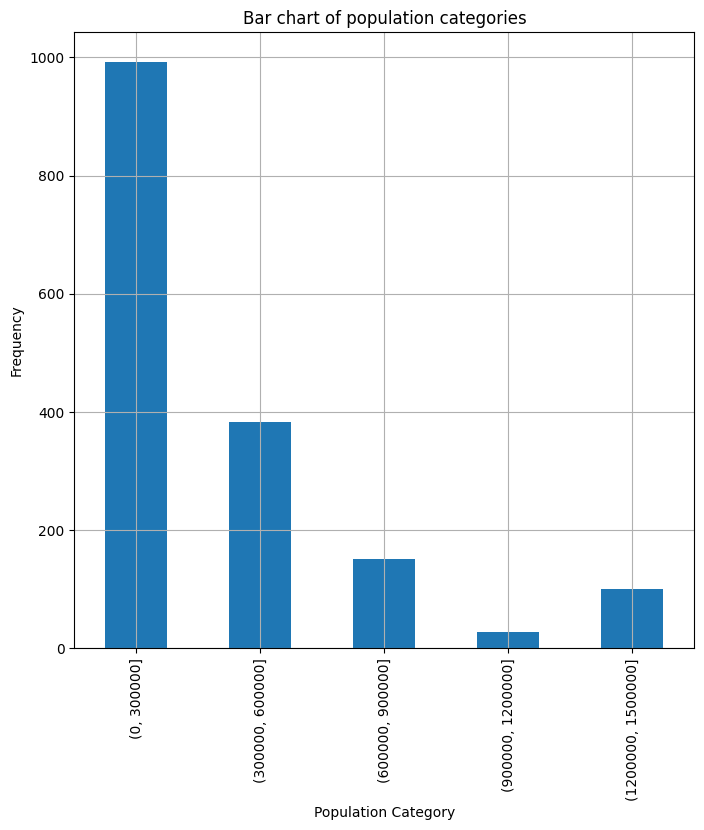

<Axes: xlabel='high_population'>

Text(0.5, 1.0, 'Population Category by City Size')

Text(0.5, 0, 'High Population')

Text(0, 0.5, 'Frequency')

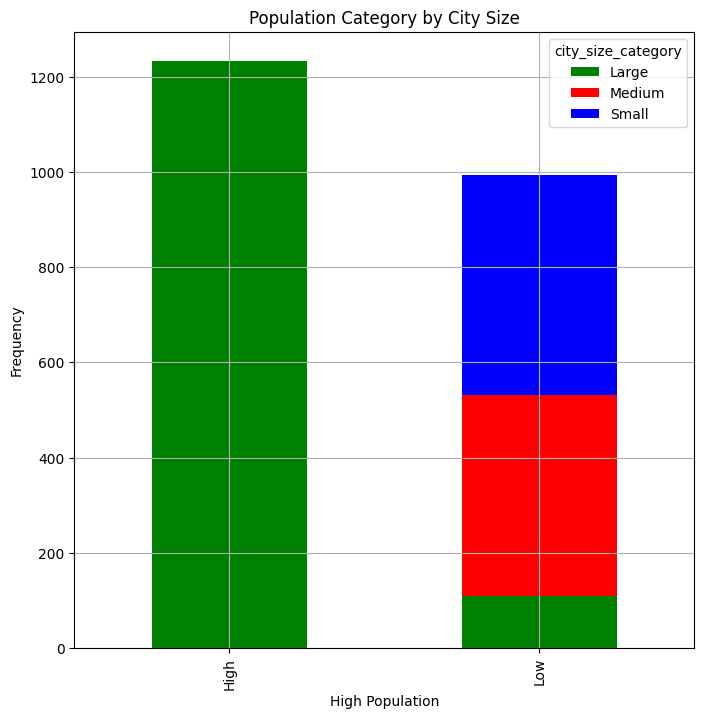

In [124]:
# Define bins for population categories
population_bins = pd.interval_range(start=0, end=1500000, freq=300000)
dataRead_new['population_category'] = pd.cut(dataRead_new['sum_municipal_population_2021'], bins=population_bins)

# Plot bar chart for the new categorical variable
dataRead_new['population_category'].value_counts().sort_index().plot.bar(figsize=(8, 8))
plt.title('Bar chart of population categories')
plt.xlabel('Population Category')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Creating another categorical variable based on a threshold
dataRead_new['high_population'] = dataRead_new['sum_municipal_population_2021'].apply(lambda x: 'High' if x >= 300000 else 'Low')

# Crosstabulation and bar chart
population_crosstab = pd.crosstab(dataRead_new['high_population'], dataRead_new['city_size_category'])
population_crosstab.plot.bar(stacked=True, figsize=(8, 8), color=['green', 'red', 'blue'])
plt.title('Population Category by City Size')
plt.xlabel('High Population')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### One hot encoder
Transform categorical variables into binary vectors using one-hot encoding.
This is necessary for machine learning models that require numerical input.

In [ ]:
dataRead_new.dtypes

In [ ]:
# One-hot encoding
ohe = OneHotEncoder(sparse_output=False, drop='first')

columns_to_encode = ['drg_segment',
                     'wifi_service',
                     'city_attraction_area',
                     'city_size_category',
                     'Dubious',
                     'high_population',
                     ]

# Fit and transform the data
encoded_data = ohe.fit_transform(dataRead_new[columns_to_encode])
 
# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(columns_to_encode))

result_df = pd.concat([dataRead_new.drop(columns_to_encode, axis=1), encoded_df], axis=1)

result_df.columns

## SECTION:9 NORMALIZATION

If you try to train a model with varaibles of ranges too far away it will be a disaster most of the times. Becasue the model might only "see" the bigger variable.

To avoid this issue you usualy normalize or standarize your data. This way you force all your variables to have the same range.
There are models that are very sensitive to this and might even fail to converge if you don't normalize your data.

The most comon transformations for normalizing the data are:
* Standarization: $\frac{X - \mu}{\sigma}$ will trasnform your data so it has mean 0 and std 1.
* Min-max scaling: $\frac{X - X_{min}}{X_{max} - X_{min}}$ will send your data to the range [0,1]
* Boxcox transformation: $\frac{X^\lambda - 1}{ \lambda}$ if $\lambda \neq 0$ or $ln(X)$ if $\lambda = 0$ transforms the data to try to fit a normal distribution.

In [ ]:
# Convert infinite values to NaN
dataRead_new.replace([np.inf, -np.inf], np.nan, inplace=True)

# Summary statistics before normalization
dataRead_new[['total_passengers_2022', 'total_passengers_and_non_passengers_2022']].describe()

In [ ]:
# Min-max scaling
min_max_scaler = preprocessing.MinMaxScaler()
dataRead_new[['total_passengers_2022_min_max', 'total_passengers_and_non_passengers_2022_min_max']] = min_max_scaler.fit_transform(dataRead_new[['total_passengers_2022', 'total_passengers_and_non_passengers_2022']])

In [ ]:
# Standardization
std_scaler = preprocessing.StandardScaler()
dataRead_new[['total_passengers_2022_std', 'total_passengers_and_non_passengers_2022_std']] = std_scaler.fit_transform(dataRead_new[['total_passengers_2022', 'total_passengers_and_non_passengers_2022']])

In [ ]:
# Boxcox transformation
# Adding a small constant to avoid log of zero
dataRead_new['total_passengers_2022_bx'], _ = boxcox(dataRead_new['total_passengers_2022'] + 1)
dataRead_new['total_passengers_and_non_passengers_2022_bx'], _ = boxcox(dataRead_new['total_passengers_and_non_passengers_2022'] + 1)

In [ ]:
# Summary statistics after normalization
dataRead_new[['total_passengers_2022_min_max', 'total_passengers_and_non_passengers_2022_min_max',
              'total_passengers_2022_std', 'total_passengers_and_non_passengers_2022_std',
              'total_passengers_2022_bx', 'total_passengers_and_non_passengers_2022_bx']].describe()

In [ ]:
# Plot histograms for the original and transformed variables
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Original histograms
dataRead_new['total_passengers_2022'].hist(bins=30, ax=axes[0, 0], color='green')
axes[0, 0].set_title('Original total_passengers_2022')
dataRead_new['total_passengers_and_non_passengers_2022'].hist(bins=30, ax=axes[0, 1], color='green')
axes[0, 1].set_title('Original total_passengers_and_non_passengers_2022')

# Min-max scaled histograms
dataRead_new['total_passengers_2022_min_max'].hist(bins=30, ax=axes[0, 2], color='red')
axes[0, 2].set_title('Min-max scaled total_passengers_2022')
dataRead_new['total_passengers_and_non_passengers_2022_min_max'].hist(bins=30, ax=axes[0, 3], color='red')
axes[0, 3].set_title('Min-max scaled total_passengers_and_non_passengers_2022')

# Standardized histograms
dataRead_new['total_passengers_2022_std'].hist(bins=30, ax=axes[1, 0], color='blue')
axes[1, 0].set_title('Standardized total_passengers_2022')
dataRead_new['total_passengers_and_non_passengers_2022_std'].hist(bins=30, ax=axes[1, 1], color='blue')
axes[1, 1].set_title('Standardized total_passengers_and_non_passengers_2022')

# Boxcox transformed histograms
dataRead_new['total_passengers_2022_bx'].hist(bins=30, ax=axes[1, 2], color='purple')
axes[1, 2].set_title('Boxcox transformed total_passengers_2022')
dataRead_new['total_passengers_and_non_passengers_2022_bx'].hist(bins=30, ax=axes[1, 3], color='purple')
axes[1, 3].set_title('Boxcox transformed total_passengers_and_non_passengers_2022')

plt.tight_layout()
plt.show()

In [ ]:
# Extra plot for Boxcox transformation
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
dataRead_new['total_passengers_2022'].plot.hist(title='Original total_passengers_2022', ax=ax)

# Apply Boxcox transformation
x, _ = boxcox(dataRead_new['total_passengers_2022'] + 1)
dataRead_new['total_passengers_2022_BC'] = x
ax = fig.add_subplot(1, 2, 2)
dataRead_new['total_passengers_2022_BC'].plot.hist(title='Boxcox transformed total_passengers_2022', ax=ax)

plt.tight_layout()
plt.show()

## SECTION 10: FEATURE SELECTION

In [ ]:
dataset = dataRead_new.copy()
dataset.columns
dataset.head(5)

In [ ]:
dataset.drop(columns=[
    'city_name',
    'total_passengers_and_non_passengers_2022',
    'total_passengers_2015',
    'total_passengers_and_non_passengers_2015',
    'city_label',
])

## SECTION 10: ENDING THE PREPROCESSING

  
 Shuffle the data (to avoid possible ordering biases)

In [ ]:
# Set the seed for reproducibility
np.random.seed(144)

# Shuffle the data
dataRead_new = dataRead_new.sample(frac=1).reset_index(drop=True)

In [ ]:
# Save the preprocessed data as a pickle file with compression
dataRead_new.to_pickle('dataRead_processed.pkl.bz2', compression='bz2')
dataRead_new.to_csv('dataset_preprocessed.csv', index=False)

# Load the preprocessed data to verify
dataRead_load = pd.read_pickle('dataRead_processed.pkl.bz2', compression='bz2')

# Display the first few rows of the loaded data
dataRead_load.head()